## Trabajo Semanal 4 - BETTIG
### Primeras nociones de estimación espectral

Para una señal:
$$ x(k) = a_1.sen(\ohm_1.k) + n(k)$$
Siendo:
$$ \ohm_1 = \ohm_0 + f_r\frac{2\pi}{N}$$
$$ \ohm_0 = \frac{\pi}{2}$$
Y las variables aleatorias definidas por:
$$ f_r \sim U(-\frac{1}{2}, \frac{1}{2}) $$
$$ n \sim N(0, \sigma^2)$$ 
Evalúe los siguientes estimadores de $ a_1 $ y $ \ohm_1 $:
$$ \hat{a_1} = |{X^i}_w(\ohm)| = |F\{x(k).w_i(k)\}|$$
$$ \hat{\ohm_1} = arg_f\{Max\{\hat{P}\}\}$$
Siguiendo las siguientes consignas:
 - Considere 200 realizaciones de 1000 muestras para cada experimento.
 -  Parametrice para SNR's de 3 y 20 db.

### Desarrollo del Trabajo

Primero que nada, voy a incluir las bibliotecas necesarias para el desarrollo de la tarea

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg

def sin_gen(vmax = 1, dc = 0, ff = 1, ph = 0, nn = 1000, fs = 1000):
    # Lo primero que hay que hacer es crear un vector temporal que determinará
    # el inicio y el fin de la señal
    ts = 1/fs   # Tiempos de muestreo, intervalo de tiempo en el que se  
                # tomarán las muestras
    tf = nn * ts # Tiempo final de la señal
    tt = np.arange(0, tf, ts) # Creo el vector temporal
    ##
    # Ahora tengo que generar mi señal senoidal, para eso voy a aprovechar
    # la función np.sin de la biblioteca numpy. Para ello, debemo evaluar
    # dicha función en cada uno de los puntos del vector temporal creado
    # previamente
    xx = vmax * np.sin(2 * np.pi * ff * tt + ph) + dc
    ##
    # Devuelvo el vector temporal y el valor de la señal en cada uno de esos
    # puntos
    return tt, xx

# Sabemos que la varianza de una función aleatoria con distribución
# uniforme puede ser calculada como Var(X) = q²/12
def rnd_nmbrs_gen(var, N):
    q = math.sqrt(var*12);
    rnd_numbers = q * np.random.random(N) - (q/2);
    return rnd_numbers;

# El objetivo de la función es obtener una señal aleatoria a partir de una
# relación señal a ruido definida por parámetro, considerando como señal
# una senoidal de amplitud normalizada ( sqrt(2) ) 
def noise_gen(snr, N):
    # Lo primero que tenemos que hacer es obtener la varianza de la señal
    # aleatoria, tengamos en cuenta que esto está normalizado, por lo que
    # luego habría que desnormalizar
    var = np.power(10.0,snr/(-10.0));
    return rnd_nmbrs_gen(var, N);

Voy a definir algunas variables de entorno que me per,itirán parametrizar la experiencia. En primer instancia, el número de realizaciones (n_run en el código) será de 200 y la SNR será de 3dB

In [2]:
# Con esta frecuencia representaré la señal analógica 
# (voy a trabajar normalizado)

f_cont  = 1000      # Frecuencia continua
N       = f_cont    # Cantidad de muestras de señal continua

# Establezco  la relación señal a ruido que tendrá y la amplitud 
# de la misma (Potencia unitaria)

snr     = 3                 # Relación señal a ruido
A_sin   = math.sqrt(2);     # Amplitud de Senoidal para potencia normalizada

# Por otro lado, la experiencia tendrá "n_run" realizaciones, por lo que me voy
# a crear una matriz vacía que contemple todas las muestras

n_run = 200;
y_sin = np.empty((n_run, N), float);
y_noise = np.empty((n_run, N), float);
noisy_sin = np.empty((n_run, N), float);

Voy a definir las 200 señales senoidales con sus correspondientes ruidos aleatorios para podes realizar la tarea. Hay que tener en cuenta que el jitter que se agrega a la frecuencia de la señal también dependerá de la realización, no es el mismo para todas:

In [5]:
for i in range(n_run):
    # Primero voy a generar la secuencia de números aleatorios que va representar
    # mi variación en frecuencia (jitter)
    q = 0.5;
    ohmega_0 = f_cont/4;
    fr = np.random.uniform(-q,q);
    ohmega = ohmega_0 + fr
    
    # Ahora voy a generar mi senoidal con la frecuencia obtenida anteriormente
    t, y_sin[i] = sin_gen(A_sin, 0, ohmega, 0, N, f_cont);
    
    # Luego, voy a calcular el ruido que debo sumar a la senoidal, con
    # la SNR deseada:
    y_noise[i] = (A_sin/(math.sqrt(2))) * noise_gen(snr, N);
    
    # La señal final será la suma de ambas:
    noisy_sin[i] = y_sin[i] + y_noise[i];

En primer lugar, voy a realizar un ventaneo por otro tipo de ventana distinta a la "default" (boxcar o rectangular), como para obtener algunas conclusiones. En mi caso, voy a utilizar el tipo "Flat Top" la cual me permitirá tener un mayor discernimiento en la amplitud de la señal (según la teoría). 
<br>Por otro lado, para lograr una mejor resolución espectral y poder observar como se manifiestan cada una de estas ventanas en el espectro, voy a realizar un "zero padding", basicamente consta de aumentar la cantidad de muestras de mi vector de muestras rellenando el mismo con ceros. En mi caso, voy a aumentarlo 10 veces, por lo que la señal útil estará en las primeras 1000 muestras mientras que las demás, serán ceros.
<br> La forma de realizar esto es la siguiente:

In [8]:
# Voy a realiza el ventaneo de mi señal por la ventana Flat Top
y_flattop = noisy_sin * sg.windows.flattop(N);

# Este margen lo voy a usar para plotear solamente el area de interes
margin = 5;
# Armo unos vectores de frecuencia para poder plotear los resultados
frec_axis_cont = np.arange(0, f_cont, f_cont/N);
frec_axis_cont_filt = (frec_axis_cont > (f_cont/4 - margin)) & (frec_axis_cont <= (f_cont/4 + margin));

# Constante que utilizaré para determinar cuanto prolongaré mi vector de muestras
# para poder hacer el padding
K = 10;

# Será mi nueva resolución espectral luego del padding
df = f_cont/K/N;

# Realizo el padding de la señal ruidosa y de la señal luego del ventaneo
noisy_sin_zero = np.hstack([noisy_sin, np.zeros([n_run,(K-1)*N])])
y_flattop_zero = np.hstack([y_flattop, np.zeros([n_run,(K-1)*N])])

Voy a imprimir los resultados en dos gráficos distintos, por ún lado voy a tener los resultados sin el padding y por el otro con el padding. Para facilitar un poco la visualizción de los mismos, voy a plotear los puntos cercanos a la frecuencia central (ya que la resolución del notebook no permitiría distinguir nada si imprimo el espectro completo)

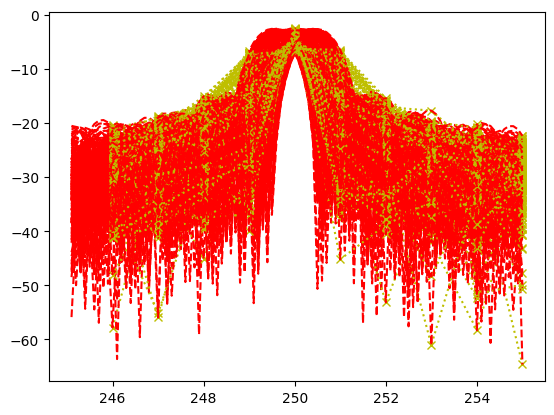

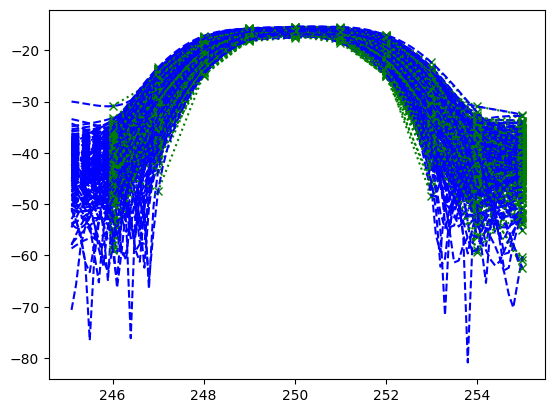

In [12]:
# Voy a generarme un nuevo eje temporal (frecuencia) y crear las matrices
# vacias donde guardaré los resultados de las FFTs

ff = np.linspace(0, (K*N-1)*df, K*N);
bfrec = (ff > (f_cont/4 - margin)) & (ff <= (f_cont/4 + margin));

fft_noisy_sin = np.empty((n_run, N), float);
fft_noisy_zero = np.empty((n_run, K*N), float);

fft_flattop      = np.empty((n_run, N), float);
fft_flattop_zero = np.empty((n_run, K*N), float);

fig1, (ax1) = plt.subplots(1);
fig2, (ax2) = plt.subplots(1);

# Ahora voy a hacer una fft para conocer el espectro de cada una de esas 
# señales que obtuve
for i in range(n_run):
    fft_noisy_sin[i]        = 20*np.log10(np.abs(np.fft.fft(noisy_sin[i])/N));
    fft_noisy_zero[i]       = 20*np.log10(np.abs(np.fft.fft(noisy_sin_zero[i])/N));
    
    fft_flattop[i]         = 20*np.log10(np.abs(np.fft.fft(y_flattop[i])/N));
    fft_flattop_zero[i]    = 20*np.log10(np.abs(np.fft.fft(y_flattop_zero[i])/N));
    
    ax1.plot(frec_axis_cont[frec_axis_cont_filt], fft_noisy_sin[i][frec_axis_cont_filt], 'x:y')
    ax1.plot(ff[bfrec], fft_noisy_zero[i][bfrec], '--r')
    
    ax2.plot(frec_axis_cont[frec_axis_cont_filt], fft_flattop[i][frec_axis_cont_filt], 'x:g')
    ax2.plot(ff[bfrec], fft_flattop_zero[i][bfrec], '--b')

Viendo los gráficos anteriores ya podemos sacar algunas conclusiones:
 - Observando el primer gráfico, tenemos la señal amarilla, que es la FFT de las distintas realiaciones y la roja que es la FFT pero luego del padding. Podemos notar como el padding nos permite discernir que es lo que ocurre entre dos puntos de la señal amarilla. Esto se debe a que, como mencioné anteriorme, al hacer el padding estamos aumentando al resolución espectral. Por ende, como primera aproximación, podemos decir que hacer el zero padding es una buena técnica si necesitamos recuperar una frecuencia de interés
 - Con respecto al otro gráfico correspondiente al ventaneo, tenemos la imagen verde (sin padding) y la imagen azul (luego del padding). En primera instancia, podemos decir que el padding no mejora en ningún aspecto, hacerlo o no es prácticamente lo mismo. Si podemos decir que el ventaneo nos da una noción mas clara de la amplitud con la cual estamos tratando. Por otro lado, no parece ser muy eficaz para el discernimiento de la frecuencia de interés.

<br> Esto que mencioné podemos verlo a través de algunos estimadores.
 - Para la amplitud, se obtendrá el valor de amplitud en la frecuencia central.
 - Para la frecuencia, se buscará el valor máximo de la señal (en frecuencia) y se obtendrá su argumento.

#### Estimación de Amplitud
Voy a comenzar planteando el estimador de amplitud como mencioné anteriormente:


Estimación de Amplitud

BoxCar -> La media es de: -4.336424323553474 y su varianza: 1.4531314752775648
Flat Top -> La media es de: -16.331123263817247 y su varianza: 0.13418886122168724


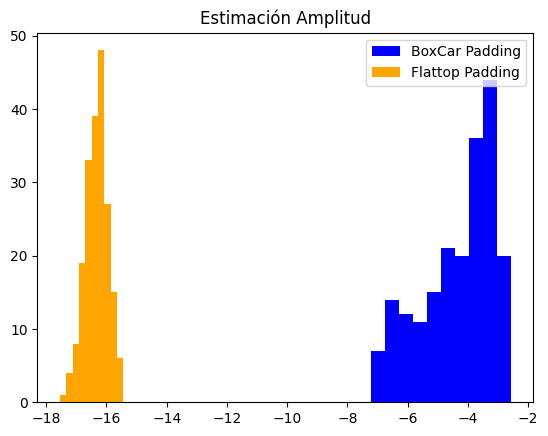

In [17]:
# Lo próximo que voy a hacer es obtener los estimadores
# Voy a comenzar con el estimador de amplitud, para ello voy a centrarme en 
# la frecuencia central (f_cont*K/4) y voy a guardar el valor de amplitud para
# cada realización
    
est_amp_noisy_zero      = np.empty((n_run, 1), float);
est_amp_flattop_zero   = np.empty((n_run, 1), float);

for i in range(n_run):
    est_amp_noisy_zero[i]      = fft_noisy_zero[i][2500];
    est_amp_flattop_zero[i]    = fft_flattop_zero[i][2500];

# Voy a imprimir los resultados:
fig3, (ax1) = plt.subplots(1);
plt.title('Estimación Amplitud')
ax1.hist(est_amp_noisy_zero, color = 'blue', label = 'BoxCar Padding', bins = 10);
ax1.hist(est_amp_flattop_zero, color = 'orange', label = 'Flattop Padding', bins = 10);
ax1.legend(loc = 'upper right');

print("\nEstimación de Amplitud\n")

# Obtengo los estadísticos de cada estimador
boxcar_amp_mean =  np.mean(est_amp_noisy_zero);
boxcar_amp_var =  np.var(est_amp_noisy_zero);
print("BoxCar -> La media es de:", boxcar_amp_mean, "y su varianza:", boxcar_amp_var)
flattop_amp_mean =  np.mean(est_amp_flattop_zero);
flattop_amp_var =  np.var(est_amp_flattop_zero);
print("Flat Top -> La media es de:", flattop_amp_mean, "y su varianza:", flattop_amp_var)


De esta primera experiencia, podemos concluir que para una estimación de amplitud, es conveniente realizar el ventaneo. Recordemos que a menor varianza, mejor el estimador, por lo que el estimador de amplitud de la señal luego del ventaneo será mejor que el otro.
<br> Otro estimador que podríamos plantear para mejorar esto es, en lugar de tomar un único punto, integrar una banda que consideremos útil.

#### Estimación de Frecuencia
Seguido de ello, pasaré a mostrar la estimación de frecuencia:


Estimación de Frecuencia

BoxCar -> La media es de: 250.01 y su varianza: 0.009899999999999999
Flat Top -> La media es de: 249.98 y su varianza: 0.29960000000000003
BoxCar Padding-> La media es de: 249.98949999999996 y su varianza: 0.08983975000000088
Flat Top Padding-> La media es de: 249.98449999999997 y su varianza: 0.308309750000001


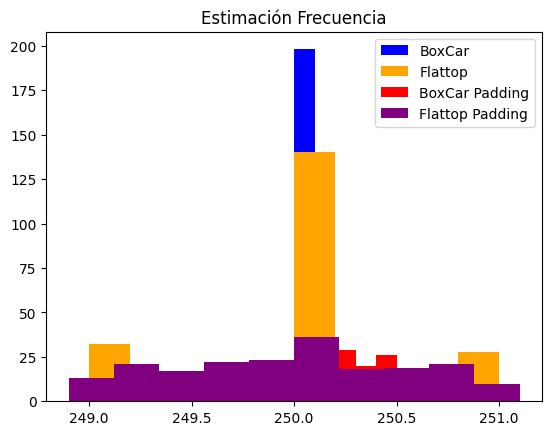

In [18]:
# Ahora voy a obtener el estimador de frecuencia, para ello voy abuscar el valor 
# mas alto de amplitud y me voy a quedar con el argumento de dicho valor
# (el cual representaría el valor de frecuencia)
frec_axis_cont_filt = frec_axis_cont <= f_cont/2;
bfrec = ff <= (f_cont/2);
est_frec_noisy          = np.empty((n_run, 1), float);
est_frec_flattop        = np.empty((n_run, 1), float);
est_frec_noisy_zero     = np.empty((n_run, 1), float);
est_frec_flattop_zero   = np.empty((n_run, 1), float);

for i in range(n_run):
    est_frec_noisy[i]           = np.argmax(fft_noisy_sin[i][frec_axis_cont_filt]);
    est_frec_flattop[i]         = np.argmax(fft_flattop[i][frec_axis_cont_filt]);
    est_frec_noisy_zero[i]      = np.argmax(fft_noisy_zero[i][bfrec])/10;
    est_frec_flattop_zero[i]    = np.argmax(fft_flattop_zero[i][bfrec])/10;

# Voy a imprimir los resultados:
fig4, (ax1) = plt.subplots(1);
plt.title('Estimación Frecuencia')
ax1.hist(est_frec_noisy, color = 'blue', label = 'BoxCar', bins = 10);
ax1.hist(est_frec_flattop, color = 'orange', label = 'Flattop', bins = 10);
ax1.hist(est_frec_noisy_zero, color = 'red', label = 'BoxCar Padding', bins = 10);
ax1.hist(est_frec_flattop_zero, color = 'purple', label = 'Flattop Padding', bins = 10);
ax1.legend(loc = 'upper right');

print("\nEstimación de Frecuencia\n")
# Obtengo los estadísticos de cada estimador
boxcar_frec_mean =  np.mean(est_frec_noisy);
boxcar_frec_var =  np.var(est_frec_noisy);
print("BoxCar -> La media es de:", boxcar_frec_mean, "y su varianza:", boxcar_frec_var)
flattop_frec_mean =  np.mean(est_frec_flattop);
flattop_frec_var =  np.var(est_frec_flattop);
print("Flat Top -> La media es de:", flattop_frec_mean, "y su varianza:", flattop_frec_var)

boxcar_padding_frec_mean =  np.mean(est_frec_noisy_zero);
boxcar_padding_frec_var =  np.var(est_frec_noisy_zero);
print("BoxCar Padding-> La media es de:", boxcar_padding_frec_mean, "y su varianza:", boxcar_padding_frec_var)
flattop_frec_padding_mean =  np.mean(est_frec_flattop_zero);
flattop_frec_padding_var =  np.var(est_frec_flattop_zero);
print("Flat Top Padding-> La media es de:", flattop_frec_padding_mean, "y su varianza:", flattop_frec_padding_var)

Como mencioné anteriormente, el ventaneo a través de Flat Top no es recomendable para la estimación de frecuencia, ya que en el proceso se pierde resolución espectral.

#### Aumentar SNR
Lo último que queda por hacer es aumentar la relación señal a ruido y observar que ocurre con las simulaciones. Para ello, voy a aumentar la SNR a 20dB (antes era de 3 dB, esto me generaba una mayor dispersión en amplitud, pero en frecuencia no afectaba)

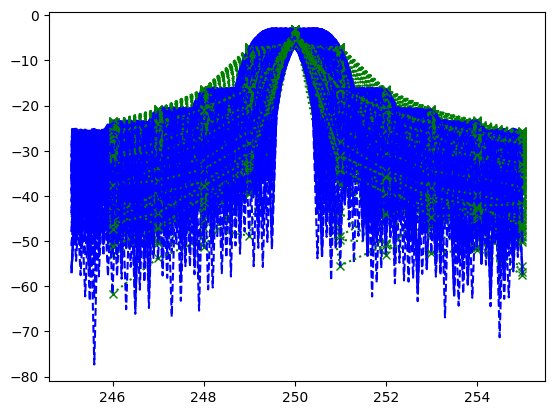

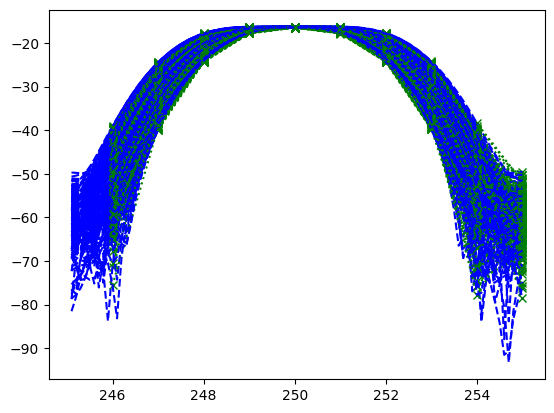

In [20]:
# Con esta frecuencia representaré la señal analógica 
# (voy a trabajar normalizado)

f_cont  = 1000      # Frecuencia continua
N       = f_cont    # Cantidad de muestras de señal continua

# Establezco  la relación señal a ruido que tendrá y la amplitud 
# de la misma (Potencia unitaria)

snr     = 20                # Relación señal a ruido
A_sin   = math.sqrt(2);     # Amplitud de Senoidal para potencia normalizada

# Por otro lado, la experiencia tendrá "n_run" realizaciones, por lo que me voy
# a crear una matriz vacía que contemple todas las muestras

n_run = 200;
y_sin = np.empty((n_run, N), float);
y_noise = np.empty((n_run, N), float);
noisy_sin = np.empty((n_run, N), float);

# # Me creo un eje temporal con el que voy a plotear mis señales
# t_axis = np.arange(0, N*1/f_cont, 1/f_cont);

for i in range(n_run):
    # Primero voy a generar la secuencia de números aleatorios que va representar
    # mi variación en frecuencia
    q = 0.5;
    ohmega_0 = f_cont/4;
    fr = np.random.uniform(-q,q);
    ohmega = ohmega_0 + fr
    
    # Ahora voy a generar mi senoidal con la frecuencia obtenida anteriormente
    t, y_sin[i] = sin_gen(A_sin, 0, ohmega, 0, N, f_cont);
    
    # Luego, voy a calcular el ruido que debo adicionar a la senoidal, con
    # la SNR deseada:
    y_noise[i] = (A_sin/(math.sqrt(2))) * noise_gen(snr, N);
    
    # La señal final será la suma de ambas:
    noisy_sin[i] = y_sin[i] + y_noise[i];

# Voy a realiza el ventaneo de mi señal por la ventana Flat Top
y_flattop = noisy_sin * sg.windows.flattop(N);

# Este margen lo voy a usar para plotear solamente el area de interes
margin = 5;
# Armo unos vectores de frecuencia para poder plotear los resultados
frec_axis_cont = np.arange(0, f_cont, f_cont/N);
frec_axis_cont_filt = (frec_axis_cont > (f_cont/4 - margin)) & (frec_axis_cont <= (f_cont/4 + margin));

# Constante que utilizaré para determinar cuanto prolongaré mi vector de muestras
# para poder hacer el padding
K = 10;

# Será mi nueva resolución espectral luego del padding
df = f_cont/K/N;

# Realizo el padding de la señal ruidosa y de la señal luego del ventaneo
noisy_sin_zero = np.hstack([noisy_sin, np.zeros([n_run,(K-1)*N])])
y_flattop_zero = np.hstack([y_flattop, np.zeros([n_run,(K-1)*N])])

# Voy a generarme un nuevo eje temporal (frecuencia) y crear las matrices
# vacias donde guardaré los resultados de las FFTs

ff = np.linspace(0, (K*N-1)*df, K*N);
bfrec = (ff > (f_cont/4 - margin)) & (ff <= (f_cont/4 + margin));

fft_noisy_sin = np.empty((n_run, N), float);
fft_noisy_zero = np.empty((n_run, K*N), float);

fft_flattop      = np.empty((n_run, N), float);
fft_flattop_zero = np.empty((n_run, K*N), float);

fig1, (ax1) = plt.subplots(1);
fig2, (ax2) = plt.subplots(1);

# Ahora voy a hacer una fft para conocer el espectro de cada una de esas 
# señales que obtuve
for i in range(n_run):
    fft_noisy_sin[i]        = 20*np.log10(np.abs(np.fft.fft(noisy_sin[i])/N));
    fft_noisy_zero[i]       = 20*np.log10(np.abs(np.fft.fft(noisy_sin_zero[i])/N));
    
    fft_flattop[i]         = 20*np.log10(np.abs(np.fft.fft(y_flattop[i])/N));
    fft_flattop_zero[i]    = 20*np.log10(np.abs(np.fft.fft(y_flattop_zero[i])/N));
    
    ax1.plot(frec_axis_cont[frec_axis_cont_filt], fft_noisy_sin[i][frec_axis_cont_filt], 'x:g')
    ax1.plot(ff[bfrec], fft_noisy_zero[i][bfrec], '--b')
    
    ax2.plot(frec_axis_cont[frec_axis_cont_filt], fft_flattop[i][frec_axis_cont_filt], 'x:g')
    ax2.plot(ff[bfrec], fft_flattop_zero[i][bfrec], '--b')


Estimación de Amplitud

BoxCar -> La media es de: -4.377835300345884 y su varianza: 1.5372467318504106
Flat Top -> La media es de: -16.348139901686977 y su varianza: 0.002392050523794274


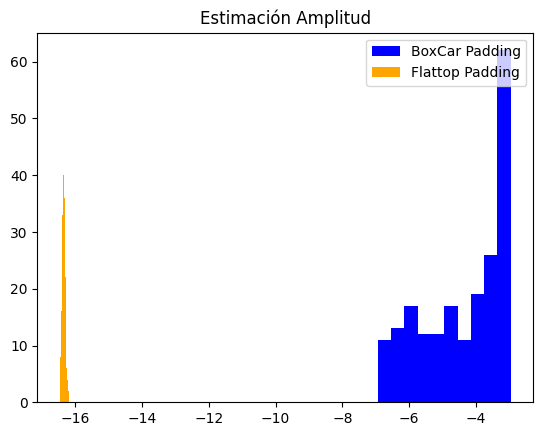

In [22]:
# Lo próximo que voy a hacer es obtener los estimadores
# Voy a comenzar con el estimador de amplitud, para ello voy a centrarme en 
# la frecuencia central (f_cont*K/4) y voy a guardar el valor de amplitud para
# cada realización
    
est_amp_noisy_zero      = np.empty((n_run, 1), float);
est_amp_flattop_zero   = np.empty((n_run, 1), float);

for i in range(n_run):
    est_amp_noisy_zero[i]      = fft_noisy_zero[i][2500];
    est_amp_flattop_zero[i]    = fft_flattop_zero[i][2500];

# Voy a imprimir los resultados:
fig3, (ax1) = plt.subplots(1);
plt.title('Estimación Amplitud')
ax1.hist(est_amp_noisy_zero, color = 'blue', label = 'BoxCar Padding', bins = 10);
ax1.hist(est_amp_flattop_zero, color = 'orange', label = 'Flattop Padding', bins = 10);
ax1.legend(loc = 'upper right');

print("\nEstimación de Amplitud\n")

# Obtengo los estadísticos de cada estimador
boxcar_amp_mean =  np.mean(est_amp_noisy_zero);
boxcar_amp_var =  np.var(est_amp_noisy_zero);
print("BoxCar -> La media es de:", boxcar_amp_mean, "y su varianza:", boxcar_amp_var)
flattop_amp_mean =  np.mean(est_amp_flattop_zero);
flattop_amp_var =  np.var(est_amp_flattop_zero);
print("Flat Top -> La media es de:", flattop_amp_mean, "y su varianza:", flattop_amp_var)


Estimación de Frecuencia

BoxCar -> La media es de: 250.0 y su varianza: 0.0
Flat Top -> La media es de: 250.005 y su varianza: 0.08497499999999998
BoxCar Padding-> La media es de: 249.98399999999998 y su varianza: 0.09154400000000124
Flat Top Padding-> La media es de: 249.97299999999998 y su varianza: 0.18587099999999995


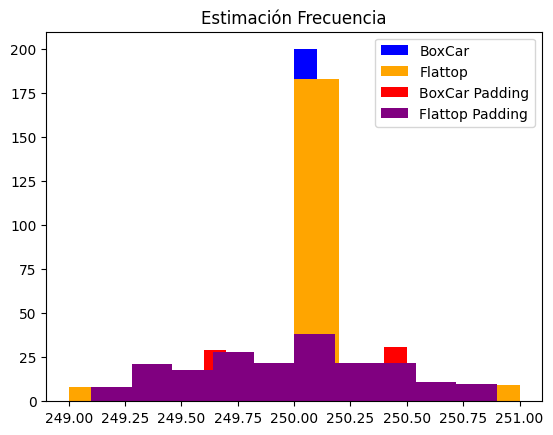

In [23]:
# Ahora voy a obtener el estimador de frecuencia, para ello voy abuscar el valor 
# mas alto de amplitud y me voy a quedar con el argumento de dicho valor
# (el cual representaría el valor de frecuencia)
frec_axis_cont_filt = frec_axis_cont <= f_cont/2;
bfrec = ff <= (f_cont/2);
est_frec_noisy          = np.empty((n_run, 1), float);
est_frec_flattop        = np.empty((n_run, 1), float);
est_frec_noisy_zero     = np.empty((n_run, 1), float);
est_frec_flattop_zero   = np.empty((n_run, 1), float);

for i in range(n_run):
    est_frec_noisy[i]           = np.argmax(fft_noisy_sin[i][frec_axis_cont_filt]);
    est_frec_flattop[i]         = np.argmax(fft_flattop[i][frec_axis_cont_filt]);
    est_frec_noisy_zero[i]      = np.argmax(fft_noisy_zero[i][bfrec])/10;
    est_frec_flattop_zero[i]    = np.argmax(fft_flattop_zero[i][bfrec])/10;

# Voy a imprimir los resultados:
fig4, (ax1) = plt.subplots(1);
plt.title('Estimación Frecuencia')
ax1.hist(est_frec_noisy, color = 'blue', label = 'BoxCar', bins = 10);
ax1.hist(est_frec_flattop, color = 'orange', label = 'Flattop', bins = 10);
ax1.hist(est_frec_noisy_zero, color = 'red', label = 'BoxCar Padding', bins = 10);
ax1.hist(est_frec_flattop_zero, color = 'purple', label = 'Flattop Padding', bins = 10);
ax1.legend(loc = 'upper right');

print("\nEstimación de Frecuencia\n")
# Obtengo los estadísticos de cada estimador
boxcar_frec_mean =  np.mean(est_frec_noisy);
boxcar_frec_var =  np.var(est_frec_noisy);
print("BoxCar -> La media es de:", boxcar_frec_mean, "y su varianza:", boxcar_frec_var)
flattop_frec_mean =  np.mean(est_frec_flattop);
flattop_frec_var =  np.var(est_frec_flattop);
print("Flat Top -> La media es de:", flattop_frec_mean, "y su varianza:", flattop_frec_var)

boxcar_padding_frec_mean =  np.mean(est_frec_noisy_zero);
boxcar_padding_frec_var =  np.var(est_frec_noisy_zero);
print("BoxCar Padding-> La media es de:", boxcar_padding_frec_mean, "y su varianza:", boxcar_padding_frec_var)
flattop_frec_padding_mean =  np.mean(est_frec_flattop_zero);
flattop_frec_padding_var =  np.var(est_frec_flattop_zero);
print("Flat Top Padding-> La media es de:", flattop_frec_padding_mean, "y su varianza:", flattop_frec_padding_var)

Se observa como todos los gráficos "convergen" en un rango mucho mas limitado de puntos, ya no es tan disperso como el caso anterior, por lo que podremos estimar la amplitud con mayor facilidad. Observemos como la varianza del estimador de amplitud con la ventana del tipo Flat Top es aún mas chica que en el caso anterior, por lo que estamos mas cerca del valor verdadero.